# API Keys

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

# Research assistant

## Generate Analysts: Human-In-The-Loop

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [3]:
from typing import List, TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

# Graph states
class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

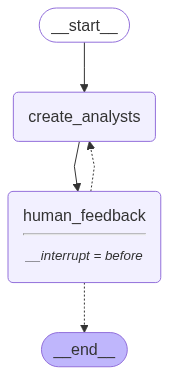

In [4]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow these instructions carefuly:

1. First, review the research topic:

{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
"""

# Graph nodes
def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """

    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(schema=Perspectives)

    system_message = analyst_instructions.format(topic=topic, max_analysts=max_analysts, human_analyst_feedback=human_analyst_feedback)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback = state.get("human_analyst_feedback", None)

    if human_analyst_feedback:
        return "create_analysts"
    
    return END

# Graph builder
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# Grpah logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
import uuid

# Thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Input
max_analysts = 3
topic = """The benefits of adopting LangGraph as an agent framework"""

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, config, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("-" * 50)

Name: Dr. Anya Sharma
Role: Senior AI Architect
Affiliation: GraphFlow Solutions
Description: Focuses on the architectural implications of agent frameworks, particularly how they handle complex state transitions, multi-agent coordination, and long-running processes. Interested in the robustness and flexibility of LangGraph's graph-based approach for intricate AI workflows.
--------------------------------------------------
Name: Mark Chen
Role: Lead Software Engineer
Affiliation: DevOps AI Labs
Description: Primarily concerned with the practical aspects of building and maintaining AI applications. His focus is on how LangGraph improves the development lifecycle, specifically in terms of error handling, traceability, and making complex agent systems easier to debug and iterate upon.
--------------------------------------------------
Name: Sarah Jenkins
Role: AI Operations Strategist
Affiliation: Enterprise AI Innovations
Description: Evaluates AI technologies from a deployment and opera

In [6]:
state = graph.get_state(config)
state.next

('human_feedback',)

In [7]:
graph.update_state(config, {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '6e6392e3-2806-402c-968a-16de5921fc19',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0777e7-81be-67b0-8002-7b45fbff67e8'}}

In [8]:
for event in graph.stream(None, config, stream_mode="values"):
    analysts = event.get("analysts", None)

    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("-" * 50)

Name: Dr. Anya Sharma
Role: Senior AI Architect
Affiliation: GraphFlow Solutions
Description: Focuses on the architectural implications of agent frameworks, particularly how they handle complex state transitions, multi-agent coordination, and long-running processes. Interested in the robustness and flexibility of LangGraph's graph-based approach for intricate AI workflows.
--------------------------------------------------
Name: Mark Chen
Role: Lead Software Engineer
Affiliation: DevOps AI Labs
Description: Primarily concerned with the practical aspects of building and maintaining AI applications. His focus is on how LangGraph improves the development lifecycle, specifically in terms of error handling, traceability, and making complex agent systems easier to debug and iterate upon.
--------------------------------------------------
Name: Sarah Jenkins
Role: AI Operations Strategist
Affiliation: Enterprise AI Innovations
Description: Evaluates AI technologies from a deployment and opera

In [9]:
state = graph.get_state(config)
state.next

('human_feedback',)

In [10]:
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '6e6392e3-2806-402c-968a-16de5921fc19',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0777e7-aa2e-64d6-8004-7464158b9d2f'}}

In [11]:
for event in graph.stream(None, config, stream_mode="values"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
topic


In [12]:
final_state = graph.get_state(config)
final_state.next

()

In [13]:
analysts = final_state.values.get("analysts")

for analyst in analysts:
    print(analyst.persona)
    print("-" * 50)

Name: Dr. Anya Sharma
Role: Senior AI Engineer
Affiliation: Leading Tech Company
Description: Focuses on the architectural advantages, ease of development, debugging, and integration aspects of LangGraph for complex AI systems.
--------------------------------------------------
Name: Mark Chen
Role: MLOps Specialist
Affiliation: Cloud Provider / Enterprise Solutions
Description: Concerned with the operational aspects, robustness, monitoring, and performance of LangGraph in large-scale, real-world applications.
--------------------------------------------------
Name: Sarah Lee
Role: Startup CTO
Affiliation: AI Startup, InnovateAI Solutions
Description: Emphasizes the speed of iteration, resource optimization, competitive advantage, and potential for rapid prototyping and deployment that LangGraph offers to agile startup environments.
--------------------------------------------------


## Conduct Interview

### Generate Question

In [14]:
import operator

from typing import Annotated
from langgraph.graph import MessagesState

# Graph states
class InterviewState(MessagesState):
    max_num_turns: int
    search_query: str
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

# Schema
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [15]:
question_instructions = """
You are analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and the ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When ou are satisfied with your understanding, complete the interviewing with: "Thank you so much for your help!"

Remember to stary in character throughout your response, reflecting the persona and goals provided to you.
"""

def generate_question(state: InterviewState):
    """ Node to generate a question"""

    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    return {"messages": [question]}

### Generate Answer: Parallelization

In [16]:
from langchain_tavily import TavilySearch

from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearch(max_results=3)

In [23]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and as expert.
                                    
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
                                    
First, analyze the full conversation.
                                    
Pay particular attention to the final question posed by the analyst.
                                    
Convert this final question into a well-structured web search query.""")

# Grpah nodes
def create_search_query(state: InterviewState):
    """ Create search query """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    return {"search_query": search_query.search_query}

def search_web(state: InterviewState):
    """ Retrieve docs from web search """

    search_query = state["search_query"]

    search_docs = tavily_search.invoke(search_query)

    formatted_search_docs = "\n\n---\n\n".join([f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs])

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    search_query = state["search_query"]

    search_docs = WikipediaLoader(query=search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join([f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs])

    return {"context": [formatted_search_docs]}

In [24]:
answer_instructions = """
You are ana expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

Your goal is to answer a question posed by the interviewer.

To answering questions, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. DO not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bootom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/> then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

# Graph nodes
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    answer.name = "expert"

    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """ Save interviews """

    messages = state["messages"]

    interview = get_buffer_string(messages)

    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """

    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    num_responses = len([message for message in messages if isinstance(message, AIMessage) and message.name == name])

    if num_responses >= max_num_turns:
        return "save_interview"
    
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    
    return "ask_question"

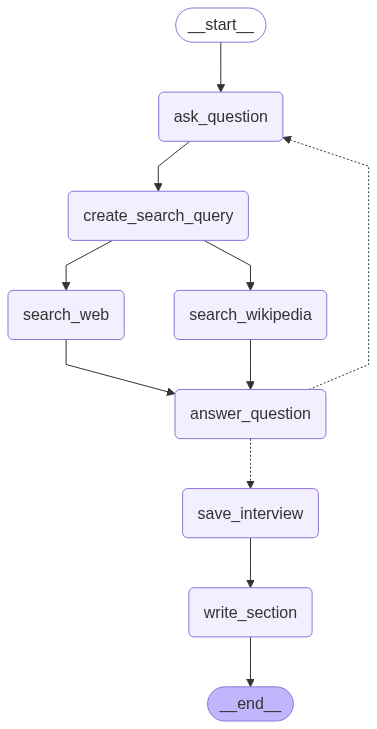

In [25]:
from langchain_core.runnables.graph import MermaidDrawMethod

section_writer_instructions = """
You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document> tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upo the focus area of the analyst:

{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewrs or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name  
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundat sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
"""

def write_section(state: InterviewState):
    """ Node to answer a question """

    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to werite your section: {context}")])

# Graph builder
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("create_search_query", create_search_query)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Graph logic
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "create_search_query")
interview_builder.add_edge("create_search_query", "search_web")
interview_builder.add_edge("create_search_query", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Graph compile
interview_memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=interview_memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [26]:
analysts[0]

Analyst(affiliation='Leading Tech Company', name='Dr. Anya Sharma', role='Senior AI Engineer', description='Focuses on the architectural advantages, ease of development, debugging, and integration aspects of LangGraph for complex AI systems.')

In [27]:
from IPython.display import Markdown

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages = [HumanMessage(content=f"So you said you were writing an article on {topic}?")]

interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, config)

Markdown(interview["sections"][0])

/home/lapig/Documentos/Github/ai-agents/.venv/lib/python3.11/site-packages/pygments/regexopt.py:63: RuntimeWarning: coroutine '_render_mermaid_using_pyppeteer' was never awaited
  + regex_opt_inner([s[plen:] for s in strings], '(?:') \


TypeError: string indices must be integers, not 'str'